In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
import os
import shutil

# Define the original data directory
original_data_path = 'data'

# Define the new directories for train, test, and validation
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for train, val, and test
subdirectories = ['good', 'ground_truth_1', 'ground_truth_2', 'oil', 'scratch', 'stain']

for split_dir in [train_dir, val_dir, test_dir]:
    for sub in subdirectories:
        os.makedirs(os.path.join(split_dir, sub), exist_ok=True)

# Define a function to split data into train, validation, and test sets
def split_data(src, dest_train, dest_val, dest_test, split_ratios=(0.7, 0.2, 0.1)):
    for sub in subdirectories:
        src_sub_dir = os.path.join(src, sub)
        files = os.listdir(src_sub_dir)
        
        # Shuffle files and split based on ratios
        num_files = len(files)
        train_count = int(num_files * split_ratios[0])
        val_count = int(num_files * split_ratios[1])
        
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        # Move files to corresponding directories
        for file in train_files:
            shutil.move(os.path.join(src_sub_dir, file), os.path.join(dest_train, sub, file))
        for file in val_files:
            shutil.move(os.path.join(src_sub_dir, file), os.path.join(dest_val, sub, file))
        for file in test_files:
            shutil.move(os.path.join(src_sub_dir, file), os.path.join(dest_test, sub, file))

# Split the data
split_data(original_data_path, train_dir, val_dir, test_dir)

base_dir


'dataset_split'

In [5]:
x_train=[]

for folder in os.listdir(train_dir):

    sub_path=train_dir+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_dir):

    sub_path=test_dir+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_dir):

    sub_path=val_dir+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [6]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1694 images belonging to 6 classes.
Found 242 images belonging to 6 classes.
Found 484 images belonging to 6 classes.


In [9]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [10]:
training_set.class_indices

{'good': 0,
 'ground_truth_1': 1,
 'ground_truth_2': 2,
 'oil': 3,
 'scratch': 4,
 'stain': 5}

In [11]:
train_y.shape,test_y.shape,val_y.shape

((1694,), (242,), (484,))

In [13]:
# Define the image size (height, width)
IMAGE_SIZE = (224, 224)  # Common size for VGG19

# Load the VGG19 model
from tensorflow.keras.applications import VGG19

vgg = VGG19(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

# Print the model summary to verify
vgg.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 143s 2us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [15]:
x = Flatten()(vgg.output)

In [26]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(6, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [27]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [29]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.7938 - loss: 4.1159 - val_accuracy: 0.9483 - val_loss: 0.7991
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9812 - loss: 0.2556 - val_accuracy: 0.9525 - val_loss: 0.7600
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.9975 - loss: 0.0155 - val_accuracy: 0.9132 - val_loss: 2.6592
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 1.0000 - loss: 3.3810e-04 - val_accuracy: 0.9855 - val_loss: 0.2661
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9975 - loss: 0.0462 - val_accuracy: 0.9773 - val_loss: 0.3005
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 416s 8s/step - accuracy: 0.9988 - loss: 0.0094 - val_accuracy: 0.8760 - val_loss: 3.1414
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9944 - loss: 0.0423 - val_accuracy: 0.9835 - val_loss: 0.4019
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9949 - loss: 0.1067 - val_accuracy: 0.9587

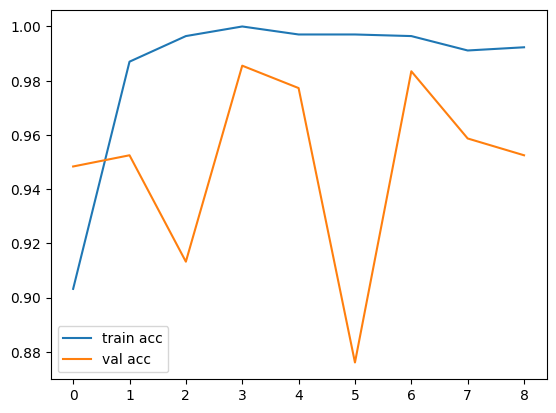

In [30]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

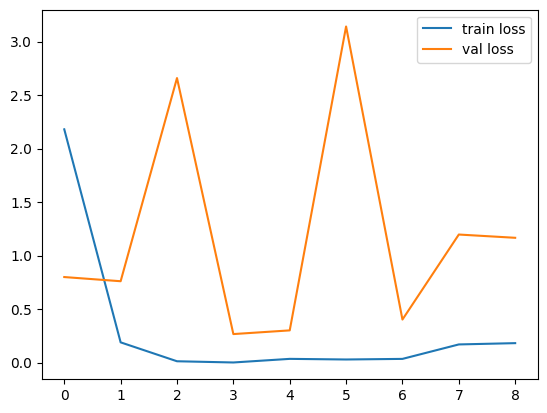

In [31]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [32]:
model.evaluate(test_x,test_y,batch_size=32)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9771 - loss: 1.2894


[1.101441740989685, 0.9462810158729553]

In [33]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

#get confusion matrix

print(confusion_matrix(y_pred,test_y))

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        40
           3       1.00      0.78      0.88        51
           4       1.00      0.95      0.98        42
           5       0.70      1.00      0.82        28

    accuracy                           0.95       242
   macro avg       0.87      0.96      0.89       242
weighted avg       0.96      0.95      0.95       242

[[ 1  0  0  0  0  0]
 [ 0 80  0  0  0  0]
 [ 0  0 40  0  0  0]
 [ 0  0  0 40  0 11]
 [ 1  0  0  0 40  1]
 [ 0  0  0  0  0 28]]


In [35]:
# Save the model to a file
model.save('my_model.keras')  # Save the model in HDF5 format


In [37]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('my_model.keras')


C:\Users\Hepzi\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

# Load the test data
test_data_generator = test_datagen.flow_from_directory(
    r'dataset_split\test',  # Directory containing test images
    target_size=(224, 224),  # Resize images to match input size
    batch_size=32,  # Adjust based on your memory limitations
    class_mode='categorical',  # Change based on your labels (binary, categorical)
    shuffle=False  # Important for evaluation, keep order
)


Found 242 images belonging to 6 classes.


In [42]:
# Get the predicted classes and true labels
predictions = loaded_model.predict(test_data_generator)
true_labels = test_data_generator.classes

# Check shapes
print("Predictions shape:", predictions.shape)  # Should be (num_samples, 6)
print("True labels shape:", true_labels.shape)  # Should be (num_samples,)



C:\Users\Hepzi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
Predictions shape: (242, 6)
True labels shape: (242,)


In [43]:
# Get predictions
predictions = loaded_model.predict(test_data_generator)

# To get the predicted classes
predicted_classes = predictions.argmax(axis=1)  # Assuming multi-class classification


8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step


In [14]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Load your trained model
model = load_model('my_model.keras')  # Change the path to your saved model

# Define the image size
IMAGE_SIZE = (224, 224)

# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0  # Assuming your model was trained on normalized data
    return img_array

# Path to the image you want to predict
image_path = r"dataset_split\train\stain\Sta_0023.jpg "# Change this to your image path
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class (assuming you have 6 classes)
predicted_class = np.argmax(predictions, axis=1)  # Get the class index with the highest probability

# Map class index to class label (adjust according to your class names)
class_labels = ['good', 'oil', 'scratch', 'stain']
predicted_label = class_labels[predicted_class[0]]

# Print the result
print(f'Predicted Class: {predicted_label}')


C:\Users\Hepzi\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Predicted Class: oil
